# Classifying genders of french words using character level LSTM in PyTorch

Nouns in french are divided in two categories, masculine and feminine. The set of rules that categorize genders is quite extensive and based mostly on word endings. There are also a lot of exceptions. We will train a character-level LSTM on french words and predict the gender of each word. 
Concretely, we will feed each character of a word as one-hot vector to a LSTM model. After the last character the model will predict the gender of the word.

The model is implemented in PyTorch.
### References
* http://pytorch.org - PyTorch
* https://github.com/spro/practical-pytorch - PracticalP PyTorch Tutorial

# Requirements

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
%matplotlib inline
from torch.autograd import Variable
import torch.optim as  optim
import torch.nn as nn
pd.set_option('display.max_rows', 2000)
from sklearn.utils import shuffle

# Preparing the Data
For this problem we are going to use lexical dictionary which is available for download here
http://www.dicollecte.org/download.php?prj=fr

In [2]:
df = pd.read_csv('~/Data/fr/lexique-dicollecte-fr-v6.0.2/lexique-dicollecte-fr-v6.0.2.txt', delimiter='\t')
df.head(3)

,id,Flexion,Lemme,Étiquettes,Métagraphe (β),Metaphone2,Notes,Sémantique,Étymologie,Sous-dictionnaire,Google 1-grams,Wikipédia,Wikisource,Littérature,Total occurrences,Doublons,Multiples,Fréquence,Indice de fréquence
0,139424,de,de,mg det epi inv,de,T,NaN,@,NaN,*,8818296701,94780970,37051349,6972501,8957101521,1,0,6.074393,9
1,145241,et,et,mg cjco,é,AT,NaN,@,NaN,*,3867624351,22249966,13925141,3823323,3907622781,1,0,2.650013,9
2,180587,à,à,mg prep prepv,a,A,NaN,@,NaN,*,3221974801,20826283,11299713,2919484,3257020281,1,0,2.208797,9


There are many fields in this dataset, but we are only interested in the column Flexion (inflection) and Étiquettes (tags). We select nouns that have tags 'sg' (singular), 'mas' (masculine) or 'fem' (feminine) tags. We also add columns word_len and gender.

In [3]:
nouns = df[df['Étiquettes'].str.contains('nom') & df['Étiquettes'].str.contains('sg') & (df['Étiquettes'].str.contains('mas') | df['Étiquettes'].str.contains('fem'))].copy()
nouns.loc[:, 'word_len'] = nouns['Flexion'].str.len()
nouns.loc[:, 'gender'] = nouns['Étiquettes'].str.contains('mas').values.astype(np.int8)
nouns = nouns[['Flexion', 'Étiquettes', 'word_len', 'gender']]

A few words in the data set contain parenthesis. We remove them.

In [4]:
nouns = nouns[~nouns['Flexion'].str.contains('\(')]

In [5]:
nouns = nouns.reindex(np.random.permutation(nouns.index))

In [6]:
print('Total nouns ' + str(len(nouns)))
nouns.head(3)

Total nouns 48940


,Flexion,Étiquettes,word_len,gender
122014,éthicien,nom adj mas sg,8,1
22602,disparité,nom fem sg,9,0
147541,dynode,nom fem sg,6,0


There are 48940 nouns in the given dataset.  Having selected the set of words and their genders we convert them to vectors.  First we create a vocabolary of all characters in the dictionary <code>char_indexes</code>. 

In [7]:
char_indexes = {}
char_index = 0
for i in range(0, len(nouns)):
    word = nouns.iloc[i].Flexion
    for j in range(0, len(word)):
        if word[j] not in char_indexes:
            char_indexes[word[j]] = char_index
            char_index += 1
VOCAB_SIZE = len(char_indexes)
VOCAB_SIZE

69

There are 69 distinct characters total. Let's find the index of the character 'a'

In [8]:
char_indexes['a']

10

Next we convert each character into a one-hot vector of the size VOCAB_SIZE with all zeros and a single one corresponding to the character index in <code>char_indexes</code>.

In [9]:
char_vectors = {}
for c, i in char_indexes.items():
    v = np.zeros(VOCAB_SIZE, np.float32)
    v[char_indexes[c]] = 1
    char_vectors[c] = v

In [10]:
char_vectors['a']

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.], dtype=float32)

The vector corresponding the letter 'a' contains a single one in the position <code>char_vectors['a']</code> with all other entries are zeros. Since our dataset is small and can fit all in memory we convert each word into a list of vectors prior to training

In [11]:
word_vectors = []
for i in range(0, len(nouns)):
    word = nouns.iloc[i].Flexion
    temp_list = []
    for j in range(0, len(word)):
        temp_list.append(char_vectors[word[j]])
    word_vectors.append(np.array(temp_list, np.float32))
word_vectors = np.array(word_vectors)    

In [12]:
word_vectors[0].shape

(8, 69)

The first noun in the dataset consists of 15 characters. The vectorized representation of this word is a 15 by 69 matrix. In order to take advantage of batch computation we need to make sure each word in the batch has the same length. A common solution to this problem is to pad sequences to the desired length with dummy characters. Let's create a histogram of word lengths in our data set. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1427160ba8>]], dtype=object)

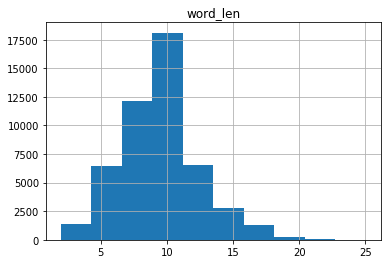

In [13]:
nouns[['word_len']].hist()

The length of french nouns vary from 2 to 20, and even if we excluded very short and very long sentences, we would be still left with a wide range of different word lengts and padding all shorter words to some maximum would and running them through the network would be very inneficient. Instead, we bucket words based on their lengths and then train and test the model bucket by bucket. 
Our data set is relatively small, so we omit the validation set and split the words in training and test set. 

In [14]:
word_len_vectors_train = {}
word_len_vectors_test = {}
# Keep track of test indices in the nouns data frame
word_len_indices_test = {}
for word_len in range(2, 25):
    word_tensors = []
    targets = []
    for wi in range(0, 25000):
        w = word_vectors[wi]
        if w.shape[0] == word_len:
            word_tensors.append(w.reshape(w.shape[0], -1, VOCAB_SIZE))
            targets.append(int(nouns.iloc[wi].gender))            
    word_tensors = np.concatenate(word_tensors, axis=1)
    word_tensors = np.swapaxes(word_tensors, 0, 1)
    targets = np.array(targets) 
    word_len_vectors_train[word_len] = (word_tensors, targets)
    
    word_tensors = []
    targets = []
    word_len_indices = []
    for wi in range(25000, len(word_vectors)):
        w = word_vectors[wi]        
        if w.shape[0] == word_len:
            word_tensors.append(w.reshape(w.shape[0], -1, VOCAB_SIZE))
            targets.append(int(nouns.iloc[wi].gender))
            word_len_indices.append(wi)
    word_tensors = np.concatenate(word_tensors, axis=1)
    word_tensors = np.swapaxes(word_tensors, 0, 1)
    targets = np.array(targets)
    word_len_vectors_test[word_len] = (word_tensors, targets)    
    word_len_indices_test[word_len] = np.array(word_len_indices)

Below we select tensor corresponding to the french nouns of length 10 characters. 3262 is the total number of words.

In [15]:
word_len_vectors_train[10][0].shape

(3282, 10, 69)

# Char LSTM Model
The model we are using is LSTM module followed by a linear layer and Softmax layer that converts the output from the linear layer to probabilities.

In [16]:
class CharLSTMModel(nn.Module):
    
    def __init__(self, n_hidden):
        super(CharLSTMModel, self).__init__()
        self.rnn = nn.LSTMCell(VOCAB_SIZE, n_hidden)
        self.linear = nn.Linear(n_hidden, 2)
        self.softmax = nn.LogSoftmax()
        self.init_weights()
        self.n_hidden = n_hidden
        self.batch_size = batch_size

    def init_weights(self):
        initrange = 0.1
        self.linear.bias.data.fill_(1.0)
        self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, input, hidden):
        hx, cx = self.rnn(input, hidden)
        out = self.linear(hx)
        return self.softmax(out), hx, cx                  

    def init_hidden(self, batch_size):        
        return Variable(torch.zeros(batch_size, int(self.n_hidden))).cuda(), \
            Variable(torch.zeros(batch_size, int(self.n_hidden))).cuda() 

# Evaluation
Before training let's have our evaluation code ready. 

In [17]:
batch_size = 32
batch_size_eval = 128

# Feeds a batch of tensors character by character through the network. 
# Returns the final output from the network
def evaluate(word_tensors):
    hx, cx = rnn.init_hidden(word_tensors.size()[1])
    for i in range(word_tensors.size()[0]):
        outputs, hx, cx = rnn(word_tensors[i], (hx, cx))
    return outputs

# Extracts the gender from the output. 1 indicates masculine and 0 feminine
def to_gender(outputs):
    top_n, top_i = outputs.data.topk(1)  
    return top_i

# Evaluates the test data set
# Returns accuracy and the indices of words in the nouns data frame genders for which 
# were incorrectly predicted
def evaluate_model():
    correct = 0
    total = 0
    incorrect_indices = []
    
    def do_evaluate(start, end, X, Y, l):
        nonlocal correct, total, incorrect_indices
        x = Variable(X[:, start:end, :].cuda())
        y = Variable(Y[start:end].cuda())
        y_pred = to_gender(evaluate(x))        
        incorrect_batch_indices = (y.data != y_pred).cpu().numpy().nonzero()[0]
        incorrect_batch_indices = incorrect_batch_indices + start
        incorrect_batch_indices = word_len_indices_test[l][incorrect_batch_indices]
        incorrect_indices.extend(list(incorrect_batch_indices))
        correct += (y.data == y_pred).sum()
        total += y_pred.size()[0]
        
    
    for l, test_data in word_len_vectors_test.items(): 
        X = np.swapaxes(test_data[0], 0, 1)
        X = torch.from_numpy(X)
        Y = torch.from_numpy(test_data[1])
        
        xi = 0
        for xi in range(batch_size_eval, X.size()[1], batch_size_eval):
            start = xi - batch_size_eval
            end = xi
            do_evaluate(start, end, X, Y, l)
        if xi < X.size()[1] - 1:
            do_evaluate(xi, X.size()[1], X, Y, l)
    return float(correct) / float(total), incorrect_indices

We also write a function that can be used interactively to predict the gender of a single word

In [18]:
def predict_gender(word):
    temp_list = []
    for j in range(0, len(word)):
        temp_list.append(char_vectors[word[j]])
    word_tensor = Variable(torch.from_numpy(np.array(temp_list, np.float32).reshape(len(word), -1, VOCAB_SIZE)).cuda())
    hx, cx = rnn.init_hidden(1) 
    for i in range(word_tensor.size()[0]):
        outputs, hx, cx = rnn(word_tensor[i], (hx, cx)) 
    gender_i = to_gender(outputs)
    return 'masculine' if gender_i.cpu()[0][0] == 1 else 'feminine'

# Training
Now we are ready to train our network.

The function train_model
* initializes the hidden state vector
* zeroes out the gradient
* feeds each character vector in the batch into the network
* finally the loss is propaged back and the model's weights are updated. 

In [19]:
def train_model(word_tensor, target_tensor,  optimizer, loss_func):
    hx, cx = rnn.init_hidden(word_tensor.size()[1])

    optimizer.zero_grad()

    for i in range(word_tensor.size()[0]):
        output, hx, cx = rnn(word_tensor[i], (hx, cx))
    loss = loss_func(output, target_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.data[0]

Finally we initialize our model, the optimizer and loss function which is NLLLoss - negative log likelihood loss. We call train_model function with a batch of inputs and targets.  We keep loss after each epoch in <code>all_losses</code> and accuracy on the test set in <code>accuracies</code>.

In [20]:
n_hidden = 512
rnn = CharLSTMModel(n_hidden).cuda()
n_epochs = 50

# Keep track of losses for plotting
current_loss = 0
all_losses = []
accuracies = []

optimizer = optim.Adam(rnn.parameters(), lr = 0.0001)
loss_func = nn.NLLLoss()

lens = np.array(list(word_len_vectors_train.keys()))
for epoch in range(0, n_epochs):
    np.random.shuffle(lens)
    epoch_losses = []
    for l in lens:
        train_data = word_len_vectors_train[l]
        X, Y = shuffle(train_data[0], train_data[1])
        X = np.swapaxes(X, 0, 1)
        X = torch.from_numpy(X).cuda()
        Y = torch.from_numpy(Y).cuda()
        for xi in range(batch_size, X.size()[1], batch_size):
            x = Variable(X[:, xi - batch_size:xi, :])
            y = Variable(Y[xi-batch_size:xi])
            output, loss = train_model(x, y, optimizer, loss_func)
            epoch_losses.append(loss)
        if xi < X.size()[1] - 1:
            x = Variable(X[:,xi:X.size()[1],:])
            y = Variable(Y[xi:X.size()[1]])
            output, loss = train_model(x, y, optimizer, loss_func)
            epoch_losses.append(loss)
            
    acc, indices = evaluate_model()
    accuracies.append(acc)
    all_losses.append(np.mean(epoch_losses))

# Plotting Results

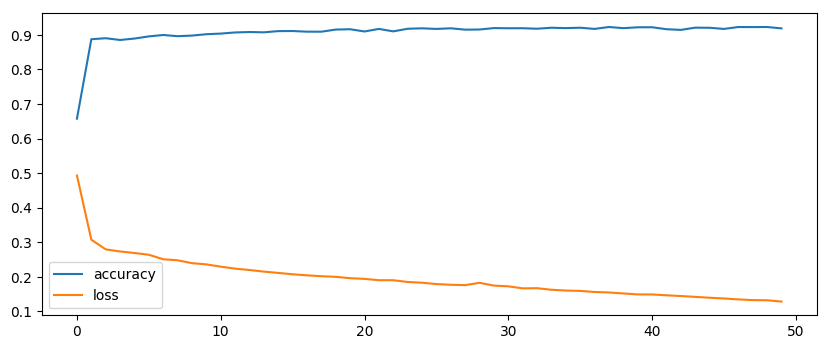

In [21]:
fig = plt.figure(figsize=(10, 4), dpi=100)
plt.plot(accuracies, label='accuracy')
plt.plot(all_losses, label='loss')
plt.legend(['accuracy', 'loss'])
plt.show()

The loss steadily decreased throughout all 50 iterations, but accuracy reached 0.9 just after a few iterations and increased a couple of decimal after about 30 iterations. 

In [22]:
accuracy, mis_labeled_indices  = evaluate_model()  

We can inspect the misclassified words by selecting rows correcponding to indices

We can check manually a few words to make sure the model works

In [23]:
predict_gender('apprentissage')  # Masculine

'masculine'

In [24]:
predict_gender('action')  # Feminine

'feminine'

In [26]:
predict_gender('machine')  # Feminine

'feminine'

We can inspect mis labeled examples in the test data set

In [27]:
nouns.iloc[mis_labeled_indices]

,Flexion,Étiquettes,word_len,gender
18611,té,nom mas sg,2,1
18978,fac,nom fem sg,3,0
742,fin,nom fem sg,3,0
2107,are,nom mas sg,3,1
8012,dot,nom fem sg,3,0
111667,rye,nom mas sg,3,1
77828,mob,nom fem sg,3,0
32737,ace,nom mas sg,3,1
50272,job,nom fem sg,3,0
599,âme,nom fem sg,3,0
